In [ ]:
# grandwin/flagging/load_outliers.py

import h5py
import numpy as np
import pandas as pd
import argparse
import os

def load_outliers_from_h5(file_path, polarizations):
    with h5py.File(file_path, "r") as f:
        outliers_mask = f["outliers_mask"][:]
        obs_id = f["obs_id"][:].astype(str)
        time_blocks = f["time_blocks"][:]

    print("Outliers: ", outliers_mask.shape)

    flat_data = outliers_mask.reshape(-1, outliers_mask.shape[-1])
    
    # Create DataFrame
    df_outliers = pd.DataFrame(flat_data, columns=["XX", "XY", "YX", "YY"])

    df_outliers["obs_id"] = np.tile(obs_id, outliers_mask.shape[1]*outliers_mask.shape[2])
    df_outliers["time_index"] = np.repeat(np.arange(outliers_mask.shape[0]), outliers_mask.shape[1] * outliers_mask.shape[2])
    df_outliers["frequency"] = np.tile(np.arange(outliers_mask.shape[2]), outliers_mask.shape[0] * outliers_mask.shape[1])
    df_outliers["antenna"] = np.tile(np.repeat(np.arange(outliers_mask.shape[1]), outliers_mask.shape[2]), outliers_mask.shape[0])
    df_outliers["obs_id"] = df_outliers['time_index'].map(lambda t: int(obs_id[t]))
    df_outliers["timeblock"] = df_outliers['time_index'].map(lambda t: int(time_blocks[t]))

    selected_polarizations = polarizations  

    # Filter rows where any of the selected columns is True
    df_outliers = df_outliers[df_outliers[selected_polarizations].any(axis=1)].reset_index(drop=True)

    return df_outliers

In [ ]:
# grandwin/flagging/apply_flags.py

from astropy.io import fits

def expand_timeblocks(timeblocks, win_step, uv_step):
    factor = int(win_step / uv_step)
    return np.array([tb * factor + i for tb in timeblocks for i in range(factor)])

def flag_uvfits_data(obs_id, uvfits_path, df_outliers, output_path, win_step, uv_step, output_dir):
    total_flags = []

    uv = fits.open(uvfits_path)

    flagsb = np.count_nonzero(uv[0].data.data[:, :, :, :, :, 2] < 0)
    datatot = np.count_nonzero(uv[0].data.data[:, :, :, :, :, 2] < 0) + np.count_nonzero(uv[0].data.data[:, :, :, :, :, 2] >= 0)
    print("Data shape before: ", uv[0].data.data.shape)
    print("Flags before: ", flagsb)
    print("Total data: ", datatot)

    _, unique_id = np.unique(uv[0].data['DATE'], return_inverse=True)

    dtimeblocks = np.unique(df_outliers['timeblock'])

    for j in range(len(dtimeblocks)):
        dfreqs = np.unique(df_outliers[df_outliers['timeblock'] == dtimeblocks[j]]['frequency'])
        print(dfreqs)

        extimeblocks = expand_timeblocks(df_outliers[df_outliers['timeblock'] == dtimeblocks[j]]['timeblock'].unique(), win_step, uv_step)
        print(extimeblocks)

        blindices = np.where(np.isin(unique_id, extimeblocks))[0]
        print(blindices)

        uv[0].data.data[np.ix_(blindices, [0], [0], dfreqs, [0,1,2,3], [2])] = np.abs(uv[0].data.data[np.ix_(blindices, [0], [0], dfreqs, [0,1,2,3], [2])]) * -1

        print("The data that being flagged ", len(dfreqs)*len(blindices)*4)
        total_flags.append(len(dfreqs)*len(blindices)*4)

    flagsa = np.count_nonzero(uv[0].data.data[:, :, :, :, :, 2] < 0)
    
    print("Data shape after: ", uv[0].data.data.shape)
    print("Flags after: ", flagsa)
    print(np.sum(total_flags))

    uv.writeto(output_path, overwrite=True)
    uv.close()

    g = str(obs_id) + ', ' + str(flagsb) + ', ' + str(flagsa) + ', ' + str(np.sum(total_flags)) + ', ' + str(datatot) + '\n'
    fflagged = open(output_dir+f"{obs_id}.log", mode='a', newline='\n')
    fflagged.write(g)
    fflagged.close()



In [ ]:
# scripts/flag_data.py

def main():
    uvfits_dir = "/Users/eormacstudio/Documents/GitHub/GRANDWin/data/raw/uvfits_raw/"
    outlier_file = "/Users/eormacstudio/Documents/GitHub/GRANDWin/data/processed/detected_outliers/3/outliers_location_day_1_grid_0_integration_8_real.h5"
    output_dir = "/Users/eormacstudio/Documents/GitHub/GRANDWin/data/processed/uvfits_update/"
    uv_integration = 2
    win_integration = 8

    df_outliers = load_outliers_from_h5(outlier_file)

    print("Outliers: ", df_outliers)
    print("Observation id: ", df_outliers["obs_id"].unique())
    unique_obs_ids = [1095451432] #df_outliers["obs_id"].unique()

    for obs_id in unique_obs_ids:
        uvfits_path = os.path.join(uvfits_dir, f"{obs_id}_w_no_flags059-078.uvfits")
        output_path = os.path.join(output_dir, f"{obs_id}_w_no_flags059-078_flagged.uvfits")
        flag_uvfits_data(
            obs_id,
            uvfits_path,
            df_outliers[df_outliers["obs_id"] == obs_id].reset_index(drop=True),
            output_path,
            win_integration,
            uv_integration
        )

if __name__ == "__main__":
    main()

In [ ]:
outlier_file = "/Users/eormacstudio/Documents/GitHub/GRANDWin/data/processed/detected_outliers/outliers_location_day_1_grid_0_integration_8_real.h5"
polarizations = ['XX', 'YY']
df_outliers = load_outliers_from_h5(outlier_file, polarizations)

In [ ]:
obs_id = 1095451432
df_outliers = df_outliers[df_outliers['obs_id'] == obs_id].reset_index(drop=True)

In [ ]:
df_outliers

In [ ]:
uvfits_dir = "/Users/eormacstudio/Documents/GitHub/GRANDWin/data/raw/uvfits_raw/"
uvfits_path = os.path.join(uvfits_dir, f"{obs_id}_w_no_flags059-078.uvfits")

total_flags = []

uv = fits.open(uvfits_path)

flagsb = np.count_nonzero(uv[0].data.data[:, :, :, :, :, 2] < 0)
datatot = np.count_nonzero(uv[0].data.data[:, :, :, :, :, 2] < 0) + np.count_nonzero(uv[0].data.data[:, :, :, :, :, 2] >= 0)
print("Data shape before: ", uv[0].data.data.shape)
print("Flags before: ", flagsb)
print("Total data: ", datatot)

date_unique, unique_id = np.unique(uv[0].data['DATE'], return_inverse=True)

dtimeblocks = np.unique(df_outliers['timeblock'])

for j in range(3): #len(dtimeblocks)):
    dfreqs = np.unique(df_outliers[df_outliers['timeblock'] == dtimeblocks[j]]['frequency'])
    print(dfreqs)

    extimeblocks = expand_timeblocks(df_outliers[df_outliers['timeblock'] == dtimeblocks[j]]['timeblock'].unique(), 8, 2)
    print(extimeblocks)

    blindices = np.where(np.isin(unique_id, extimeblocks))[0]
    print(blindices)

    uv[0].data.data[np.ix_(blindices, [0], [0], dfreqs, [0,1,2,3], [2])] = np.abs(uv[0].data.data[np.ix_(blindices, [0], [0], dfreqs, [0,1,2,3], [2])]) * -1

    print("The data that being flagged ", len(dfreqs)*len(blindices)*4)
    total_flags.append(len(dfreqs)*len(blindices)*4)

flagsa = np.count_nonzero(uv[0].data.data[:, :, :, :, :, 2] < 0)
print("Data shape after: ", uv[0].data.data.shape)
print("Flags after: ", flagsa)
print(np.sum(total_flags))

g = str(obs_id) + ', ' + str(flagsb) + ', ' + str(flagsa) + ', ' + str(np.sum(total_flags)) + ', ' + str(datatot) + '\n'
fflagged = open(result_directory+file_flagged, mode='a', newline='\n')
fflagged.write(g)
fflagged.close()

uv.writeto(raw_directory + "%s/raw_%s_w_flag059-078_updated.uvfits" %(obs_id, obs_id), overwrite=True)
uv.close()

print("Add observationid %s for flagged observation!" %(obs_id))
file = open(finished_file, mode='a', newline='')
file.write("%s \n" %(obs_id))
file.close()


In [ ]:
expand_timeblocks(df_outliers[df_outliers['timeblock'] == 3]['timeblock'].unique(), 8, 2)

In [ ]:
np.where(np.isin(unique_id, dextimeblocks))[0]

---

#### Check visibility data

In [1]:
from astropy.io import fits
import os
import numpy as np
from matplotlib import pyplot as plt

uvfits_dir = "/Volumes/eor_hdd_2/model_data_250815/"
uvfits_path = os.path.join(uvfits_dir, "visibility_model_1095450704_newthermal_strongrfi.uvfits")
uvfits_obs_path = os.path.join(uvfits_dir, "1095450704_w_flags_corrections_time_edges059-078.uvfits")

In [2]:
uv = fits.open(uvfits_path)
uv_obs = fits.open(uvfits_obs_path)

In [ ]:
uv[0].data.data.shape

In [37]:
uv[0].data['BASELINE'][0:1000]

array([ 258.,  259.,  260.,  261.,  262.,  263.,  264.,  265.,  266.,
        267.,  268.,  269.,  270.,  271.,  272.,  273.,  274.,  275.,
        276.,  277.,  278.,  279.,  280.,  281.,  282.,  283.,  284.,
        285.,  286.,  287.,  288.,  289.,  290.,  291.,  292.,  293.,
        294.,  295.,  296.,  297.,  298.,  299.,  300.,  301.,  302.,
        303.,  304.,  305.,  306.,  307.,  308.,  309.,  310.,  311.,
        312.,  313.,  314.,  315.,  316.,  317.,  318.,  319.,  320.,
        321.,  322.,  323.,  324.,  325.,  326.,  327.,  328.,  329.,
        330.,  331.,  332.,  333.,  334.,  335.,  336.,  337.,  338.,
        339.,  340.,  341.,  342.,  343.,  344.,  345.,  346.,  347.,
        348.,  349.,  350.,  351.,  352.,  353.,  354.,  355.,  356.,
        357.,  358.,  359.,  360.,  361.,  362.,  363.,  364.,  365.,
        366.,  367.,  368.,  369.,  370.,  371.,  372.,  373.,  374.,
        375.,  376.,  377.,  378.,  379.,  380.,  381.,  382.,  383.,
        384.,  515.,

In [38]:
baseline = 2164

In [39]:
num_freq_data = uv[0].data.data.shape[3]
num_freq_data_obs = uv_obs[0].data.data.shape[3]

In [40]:
uv_xx = uv[0].data.data[np.ix_(np.where(uv[0].data['BASELINE'] == baseline)[0], [0], [0], np.arange(0,num_freq_data), [0], [0,1,2])].reshape(56, num_freq_data, 3)
uv_yy = uv[0].data.data[np.ix_(np.where(uv[0].data['BASELINE'] == baseline)[0], [0], [0], np.arange(0,num_freq_data), [1], [0,1,2])].reshape(56, num_freq_data, 3)

In [41]:
uv_obs_xx = uv_obs[0].data.data[np.ix_(np.where(uv_obs[0].data['BASELINE'] == baseline)[0], [0], [0], np.arange(0,num_freq_data_obs), [0], [0,1,2])].reshape(56, num_freq_data_obs, 3)
uv_obs_yy = uv_obs[0].data.data[np.ix_(np.where(uv_obs[0].data['BASELINE'] == baseline)[0], [0], [0], np.arange(0,num_freq_data_obs), [1], [0,1,2])].reshape(56, num_freq_data_obs, 3)

Text(0.5, 0.01, 'Frequency')

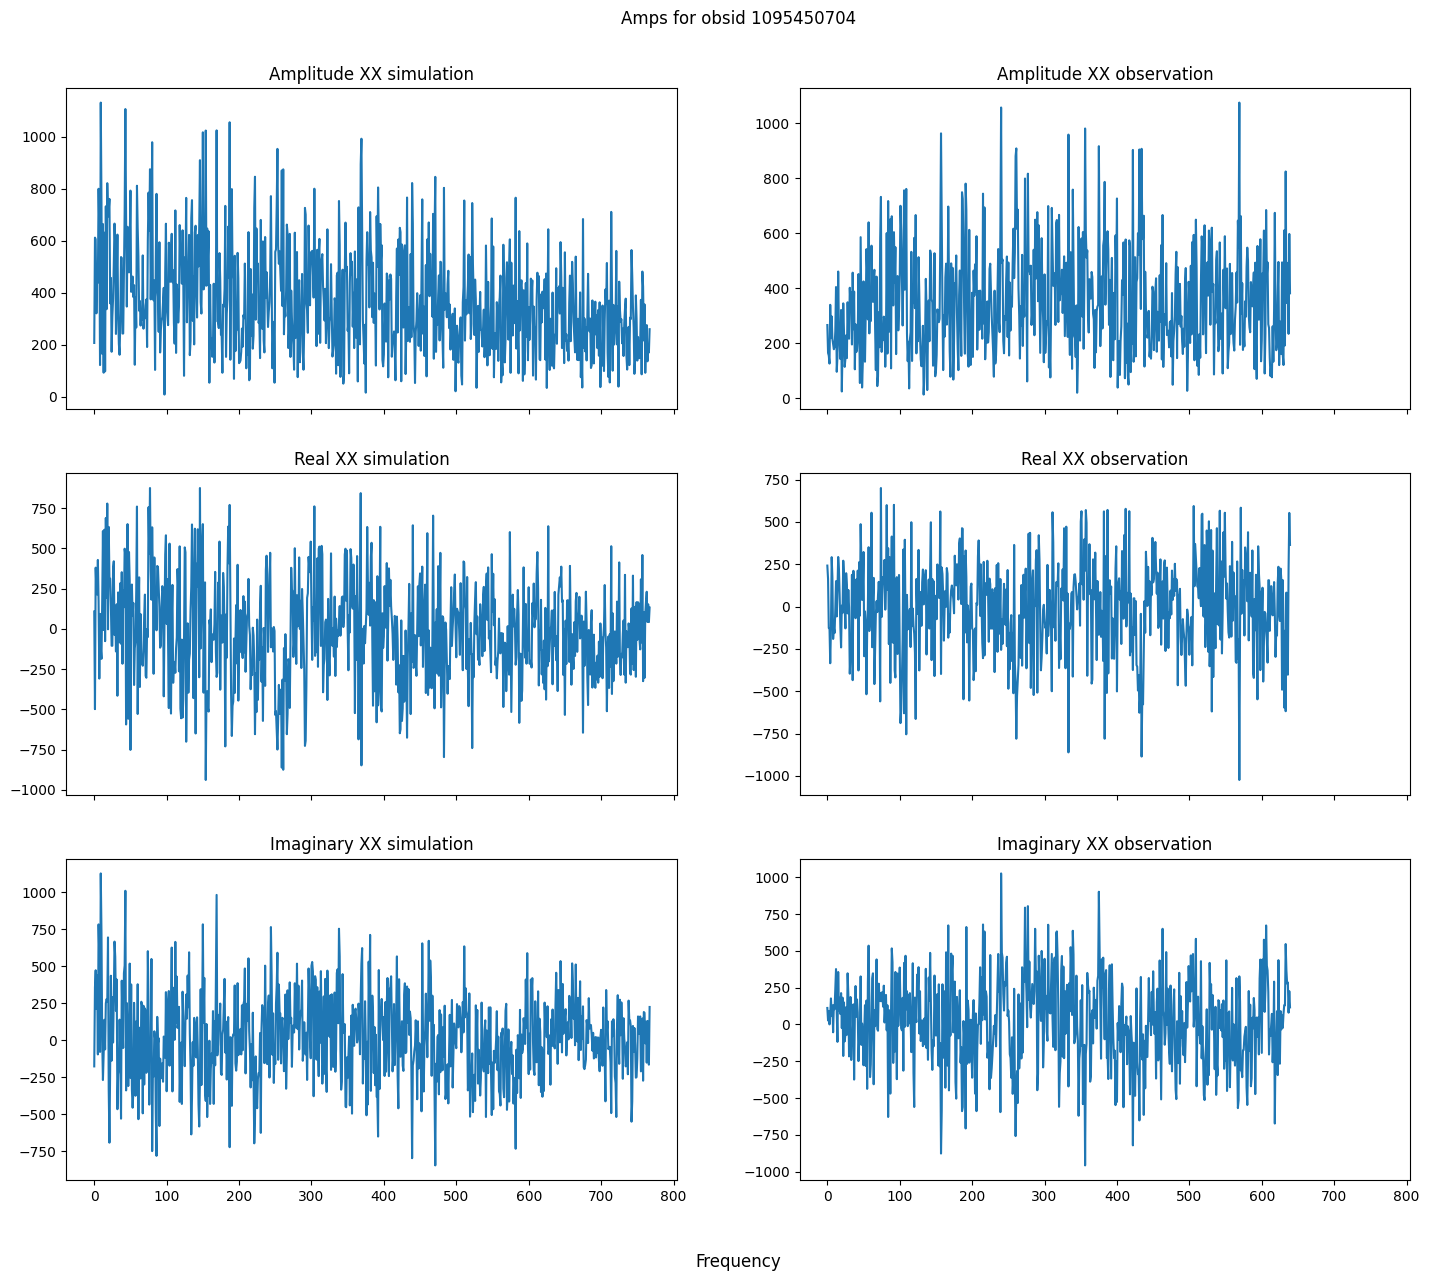

In [42]:
fig1, ax = plt.subplots(3, 2, figsize=(16, 13), sharex=True)#, sharey=True)
fig1.suptitle("Amps for obsid 1095450704", fontsize=12)
fig1.subplots_adjust(wspace=0.2, hspace=0.2, left=0.08, top=0.92, right=0.92, bottom=0.08)

# Uncomment if you want to manually set the y-limit

ax[0,0].plot(np.abs(np.sqrt(uv_xx[0, :, 0]**2 + uv_xx[0, :, 1]**2)))
ax[0,0].set_title("Amplitude XX simulation")
ax[0,1].plot(np.abs(np.sqrt(uv_obs_xx[0, :, 0]**2 + uv_obs_xx[0, :, 1]**2)))
ax[0,1].set_title("Amplitude XX observation")

ax[1,0].plot(uv_xx[0, :, 0])
ax[1,0].set_title("Real XX simulation")
ax[1,1].plot(uv_obs_xx[0, :, 0])
ax[1,1].set_title("Real XX observation")

ax[2,0].plot(uv_xx[0, :, 1])
ax[2,0].set_title("Imaginary XX simulation")
ax[2,1].plot(uv_obs_xx[0, :, 1])
ax[2,1].set_title("Imaginary XX observation")

fig1.supxlabel("Frequency", fontsize=12)

In [43]:
6.0037/15

0.4002466666666667

In [44]:
0.4002*60

24.012

In [45]:
0.012 * 60

0.72

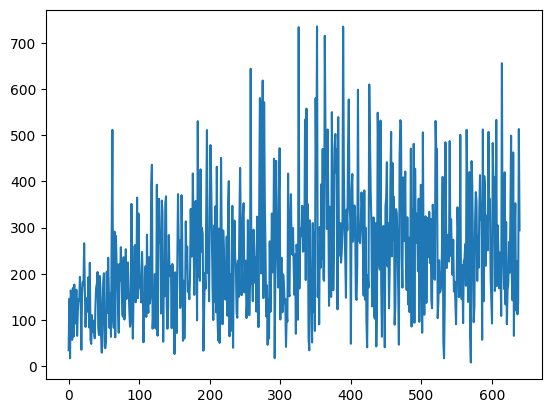

In [10]:
plt.plot(np.abs(np.sqrt(uv_obs_xx[0, :, 0]**2 + uv_obs_xx[0, :, 1]**2)))

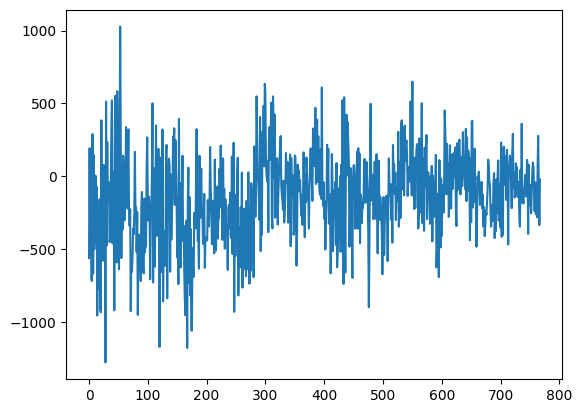

In [13]:
plt.plot(uv_xx[0, :, 1])

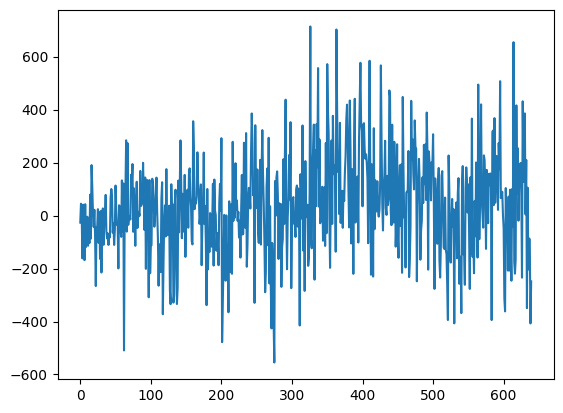

In [14]:
plt.plot(uv_obs_xx[0, :, 1])